# Control indoor CO<sub>2</sub> concentration with predictive models
We use quantile regression in <b>GradientBoostingRegressor</b> to predict high and low thresholds of indoor CO<sub>2</sub> concentration as control criteria.

Besides, the WELL standard is introduced as the rule base for IAQ control.

### Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "svg"

### Import rawdata 
The <b>data_resample</b> here is from the same dataset for CO<sub>2</sub>-prediction.

In [2]:
path = r'C:\Users\Jacky\Jupyter Projects\Office_Data'
df = pd.read_excel(path+r'\Office_k.xlsx').drop(['index'], axis=1)

# Variables for resample.mean
data_mean = pd.DataFrame(
    # Data
    dict(
        T_in=df['T_z'].values,
        RH=df['Humid'].values,
        CO2=df['CO2'].values,
        T_out=df['T_OA'].values
    ), 
    # Time Index
    df['Time'])
data_mean = data_mean.resample('10min').mean().round(1)
data_mean.reset_index(inplace=True)

# Variables for resample.max
data_max = pd.DataFrame(
    # Data from occupancy detector
    dict(Occ=df['Occ'].values), 
    # Time Index
    df['Time'])
data_max = data_max.resample('10min').max()
data_max.reset_index(inplace=True)

# Variables for resample.asfreq
data_freq = pd.DataFrame(
    # Data from ventilation device
    dict(HRV=df['HRVspeed'].values), 
    # Time Index
    df['Time'])
data_freq = data_freq.resample('10min').asfreq()
data_freq.reset_index(inplace=True)

# Merge data
data_resample = pd.merge(data_mean, data_max, how="outer", sort=True)
data_resample = pd.merge(data_resample, data_freq, how="outer", sort=True)

# Set Time variables: [Day of Week, Hour of Day]
data_resample['DoW'] = [i.weekday()+1 for i in data_resample['Time']]
data_resample['HoD'] = [(i.hour+i.minute/60) for i in data_resample['Time']]
data_resample

,Time,T_in,RH,CO2,T_out,Occ,HRV,DoW,HoD
0,2020-07-01 00:00:00,30.2,87.5,474.9,28.5,0,0.0,3,0.000000
1,2020-07-01 00:10:00,30.2,88.0,479.4,28.4,0,0.0,3,0.166667
2,2020-07-01 00:20:00,30.2,88.5,489.4,28.4,0,0.0,3,0.333333
3,2020-07-01 00:30:00,30.3,88.6,499.0,28.3,0,0.0,3,0.500000
4,2020-07-01 00:40:00,30.3,88.7,495.1,28.3,0,0.0,3,0.666667
...,...,...,...,...,...,...,...,...,...
13243,2020-09-30 23:10:00,26.5,92.9,488.4,22.6,0,0.0,3,23.166667
13244,2020-09-30 23:20:00,26.5,92.9,477.0,22.6,0,0.0,3,23.333333
13245,2020-09-30 23:30:00,26.5,92.8,484.0,22.5,0,0.0,3,23.500000
13246,2020-09-30 23:40:00,26.5,92.7,480.8,22.4,0,0.0,3,23.666667


### Set the model

In [3]:
# Features and target
df_input = data_resample[['T_in', 'RH', 'HoD', 'DoW', 'HRV']]
df_targ = data_resample['CO2']

# Model parameters
alpha = 0.95
n_estimators = 1000
lr = 0.01

# Using quantile regression in GBR
clf_high = GradientBoostingRegressor(
    loss='quantile',
    random_state=0,
    min_samples_split=10,
    n_estimators=n_estimators,
    alpha=alpha,
    max_depth=10,
    learning_rate=lr)
clf_low = GradientBoostingRegressor(
    loss='quantile',
    random_state=0,
    min_samples_split=10,
    n_estimators=n_estimators,
    alpha=1 - alpha,
    max_depth=10,
    learning_rate=lr)

# Print the models
print('train quantile high: ', clf_high.fit(df_input,df_targ))
print('train quantile low: ',clf_low.fit(df_input,df_targ))

train quantile high:  GradientBoostingRegressor(alpha=0.95, learning_rate=0.01, loss='quantile',
                          max_depth=10, min_samples_split=10, n_estimators=1000,
                          random_state=0)
train quantile low:  GradientBoostingRegressor(alpha=0.050000000000000044, learning_rate=0.01,
                          loss='quantile', max_depth=10, min_samples_split=10,
                          n_estimators=1000, random_state=0)


###  Predict the target & plot the results
Use the models for threshold predictions and prepare variables for plotting.

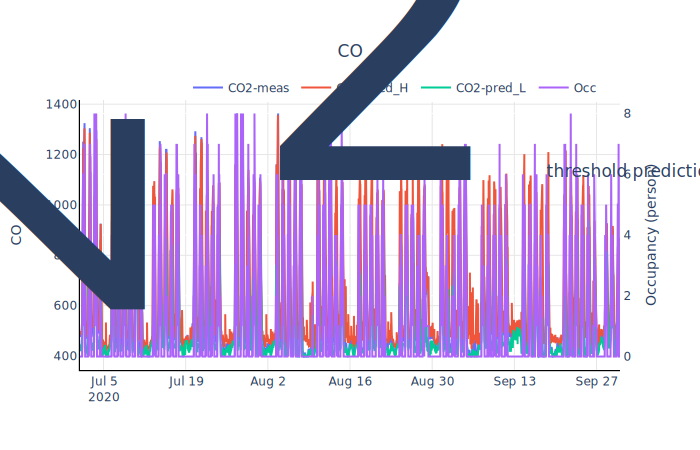

In [4]:
# Predict the high and low thresholds
df_Predict_H = pd.DataFrame(clf_high.predict(df_input), index=df_targ.index)
df_Predict_L = pd.DataFrame(clf_low.predict(df_input), index=df_targ.index)

# Concat the data and results
df_Plot = pd.concat([data_resample['Time'], df_targ, df_Predict_H, df_Predict_L, data_resample['Occ']], axis=1)
df_Plot.columns = ['Time', 'real', 'predict_H', 'predict_L', 'Occ']

# Plot measured and predicted data
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name = 'CO2-meas',
        x = df_Plot['Time'],
        y = df_Plot['real']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_H',
        x = df_Plot['Time'],
        y = df_Plot['predict_H']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_L',
        x = df_Plot['Time'],
        y = df_Plot['predict_L']
    ))
fig.add_trace(
    go.Scatter(
        name = 'Occ',
        x = data_resample['Time'],
        y = data_resample['Occ'],
        yaxis="y2"
    ))
fig.update_xaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)
fig.update_yaxes(
    title="CO<sub>2</sub> (ppm)",
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)    
fig.update_layout(
    title=dict(text="CO<sub>2</sub> threshold predictions", x=0.5, y=0.9),
    plot_bgcolor="white",
    yaxis2=dict(
        title="Occupancy (person)",
        anchor="free",
        overlaying="y",
        side="right",
        position=1),
    legend=dict(orientation="h", x=0.2, y=1.1))

We can select one day for example and further looking.

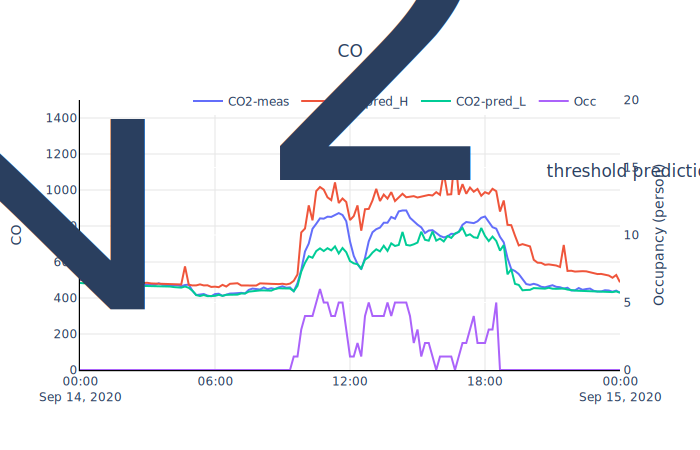

In [5]:
# Select 2020-09-14 as example
df_Plot_day = df_Plot[(df_Plot['Time'] >= '2020-09-14') & (df_Plot['Time'] <= '2020-09-15')]

# Plot the data
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name = 'CO2-meas',
        x = df_Plot_day['Time'],
        y = df_Plot_day['real']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_H',
        x = df_Plot_day['Time'],
        y = df_Plot_day['predict_H']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_L',
        x = df_Plot_day['Time'],
        y = df_Plot_day['predict_L']
    ))
fig.add_trace(
    go.Scatter(
        name = 'Occ',
        x = data_resample['Time'][(data_resample['Time'] >= '2020-09-14') & (data_resample['Time'] <= '2020-09-15')],
        y = data_resample['Occ'][(data_resample['Time'] >= '2020-09-14') & (data_resample['Time'] <= '2020-09-15')],
        yaxis="y2"
    ))
fig.update_xaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)
fig.update_yaxes(
    title="CO<sub>2</sub> (ppm)",
    range=[0, 1500],
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)    
fig.update_layout(
    title=dict(text="CO<sub>2</sub> threshold predictions", x=0.5, y=0.9),
    plot_bgcolor="white",
    yaxis2=dict(
        title="Occupancy (person)",
        range=[0, 20],
        anchor="free",
        overlaying="y",
        side="right",
        position=1),
    legend=dict(orientation="h", x=0.2, y=1.05))

Moreover, we can resample the results by median method to smooth the predictive thresholds.

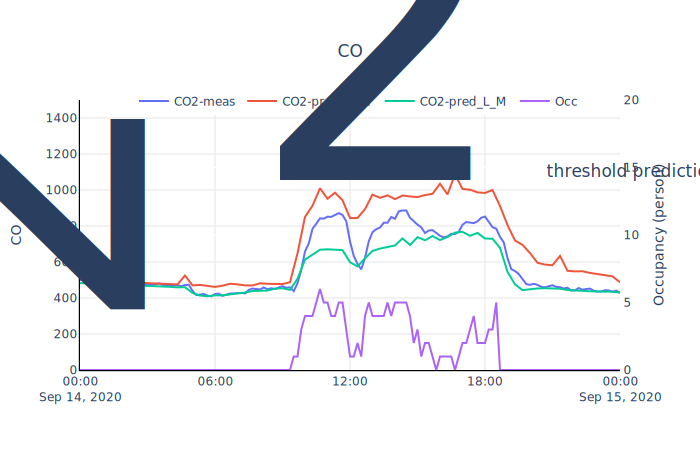

In [6]:
# For resample.median
data_median = pd.DataFrame(
    # Data from the example
    dict(P_H_M=df_Plot_day['predict_H'].values, P_L_M=df_Plot_day['predict_L'].values), 
    # Time Index
    df_Plot_day['Time'])
data_median = data_median.resample('20min').median()
data_median.reset_index(inplace=True)

# Plot the data
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name = 'CO2-meas',
        x = df_Plot_day['Time'],
        y = df_Plot_day['real']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_H_M',
        x = data_median['Time'],
        y = data_median['P_H_M']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_L_M',
        x = data_median['Time'],
        y = data_median['P_L_M']
    ))
fig.add_trace(
    go.Scatter(
        name = 'Occ',
        x = data_resample['Time'][(data_resample['Time'] >= '2020-09-14') & (data_resample['Time'] <= '2020-09-15')],
        y = data_resample['Occ'][(data_resample['Time'] >= '2020-09-14') & (data_resample['Time'] <= '2020-09-15')],
        yaxis="y2"
    ))

fig.update_xaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)
fig.update_yaxes(
    title="CO<sub>2</sub> (ppm)",
    range=[0, 1500],
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)    
fig.update_layout(
    title=dict(text="CO<sub>2</sub> threshold predictions", x=0.5, y=0.9),
    plot_bgcolor="white",
    yaxis2=dict(
        title="Occupancy (person)",
        range=[0,20],
        anchor="free",
        overlaying="y",
        side="right",
        position=1),
    legend=dict(orientation="h", x=0.1, y=1.05))


Also, we can introduce WELL standard criteria[1] as another high threshold.

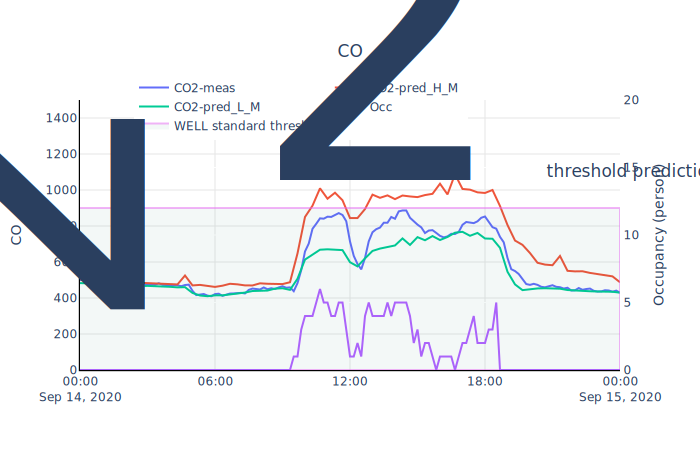

In [7]:
# For resample.median
data_median = pd.DataFrame(
    # Data from the example
    dict(P_H_M=df_Plot_day['predict_H'].values, P_L_M=df_Plot_day['predict_L'].values), 
    # Time Index
    df_Plot_day['Time'])
data_median = data_median.resample('20min').median()
data_median.reset_index(inplace=True)

# Plot the data
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name = 'CO2-meas',
        x = df_Plot_day['Time'],
        y = df_Plot_day['real']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_H_M',
        x = data_median['Time'],
        y = data_median['P_H_M']
    ))
fig.add_trace(
    go.Scatter(
        name = 'CO2-pred_L_M',
        x = data_median['Time'],
        y = data_median['P_L_M']
    ))
fig.add_trace(
    go.Scatter(
        name = 'Occ',
        x = data_resample['Time'][(data_resample['Time'] >= '2020-09-14') & (data_resample['Time'] <= '2020-09-15')],
        y = data_resample['Occ'][(data_resample['Time'] >= '2020-09-14') & (data_resample['Time'] <= '2020-09-15')],
        yaxis="y2"
    ))

# Introduce WELL standard criteria for high threshold
fig.add_trace(
    go.Scatter(
        x = list(data_median['Time'])+list(data_median['Time'][::-1]),
        y = [900 for i in range(len(data_median))]+[0 for i in range(len(data_median))],
            fill='toself',
            fillcolor='rgba(0,100,80,0.05)',
            line_color='rgba(231,107,243,0.5)',
            mode = 'lines',
            name = 'WELL standard threshold',
            yaxis='y1'))

fig.update_xaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)
fig.update_yaxes(
    title="CO<sub>2</sub> (ppm)",
    range=[0, 1500],
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)    
fig.update_layout(
    title=dict(text="CO<sub>2</sub> threshold predictions", x=0.5, y=0.9),
    plot_bgcolor="white",
    yaxis2=dict(
        title="Occupancy (person)",
        range=[0,20],
        anchor="free",
        overlaying="y",
        side="right",
        position=1),
    legend=dict(orientation="h", x=0.1, y=1.1))

The results of the <b>CO<sub>2</sub>_prediction</b> can also be applied in these threshold predections for control alarm forcasting.

### Reference
[1]

WELL standard: IAQ criteria

https://dev-wellv2.wellcertified.com/wellv2/en/air/feature/6